<a href="https://colab.research.google.com/github/samleonnn/waste-segregation/blob/main/WasteSegregation_ModelExported.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Capstone C22-PC414/AllMainData_v3.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
TRAIN_DIR = "/tmp/AllMainData_v3/TRAIN"
VAL_DIR  = "/tmp/AllMainData_v3/VAL"

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                    batch_size=128, 
                                    class_mode="categorical",
                                    target_size=(299, 299))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "training",
                                            shuffle = False)

test_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "validation",
                                            shuffle = False)

Found 21249 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


In [6]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


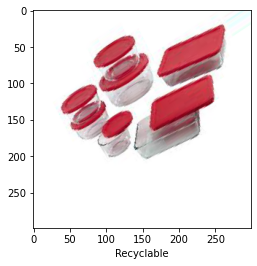

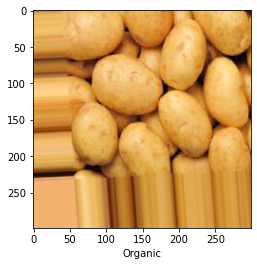

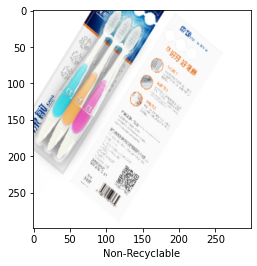

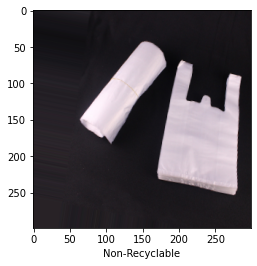

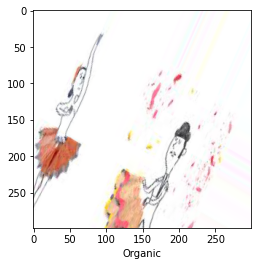

In [7]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x,y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(299, 299, 3),
                          pooling='avg')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [9]:
last_layer = pre_trained_model.get_layer('block13_sepconv2_act')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 19, 19, 728)


In [10]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [11]:
opt = "adam"

model.compile(optimizer=opt,
            loss="categorical_crossentropy",
            metrics=['accuracy']) 

In [12]:
history = model.fit(train_generator,
                    epochs = 30,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/30
167/167 [==============================] - 550s 3s/step - loss: 1.2085 - accuracy: 0.7326 - val_loss: 0.3915 - val_accuracy: 0.8278
Epoch 2/30
167/167 [==============================] - 528s 3s/step - loss: 0.3857 - accuracy: 0.8433 - val_loss: 0.4241 - val_accuracy: 0.8204
Epoch 3/30
167/167 [==============================] - 533s 3s/step - loss: 0.3638 - accuracy: 0.8556 - val_loss: 0.3550 - val_accuracy: 0.8621
Epoch 4/30
167/167 [==============================] - 528s 3s/step - loss: 0.3482 - accuracy: 0.8625 - val_loss: 0.3942 - val_accuracy: 0.8527
Epoch 5/30
167/167 [==============================] - 529s 3s/step - loss: 0.3188 - accuracy: 0.8747 - val_loss: 0.3760 - val_accuracy: 0.8568
Epoch 6/30
167/167 [==============================] - 531s 3s/step - loss: 0.3019 - accuracy: 0.8821 - val_loss: 0.3868 - val_accuracy: 0.8521
Epoch 7/30
167/167 [==============================] - 530s 3s/step - loss: 0.2819 - accuracy: 0.8889 - val_loss: 0.3717 - val_accuracy: 0.8583

In [ ]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_generator)

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(validation_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))   

In [13]:
save_path = "/content/drive/MyDrive/Capstone C22-PC414/wsmodel-21052022"
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone C22-PC414/wsmodel-21052022/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tfliteModel = converter.convert()

In [ ]:
with open("/content/drive/MyDrive/Capstone C22-PC414/wsmodel.tflite", "wb") as file:
  file.write(tfliteModel)